In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain
import networkx as nx
from fa2 import ForceAtlas2
from collections import defaultdict
from nltk.corpus import wordnet as wn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Communities</p>

In [2]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")

In [3]:
ignore_characters = ["List of aliases", "List of IT guys","Dawn Tinsley", "David Brent", "Gareth Keenan", "Lee", "Tim Canterbury", "Neil Godwin"
, "Donna (UK)"]

In [4]:
G.remove_nodes_from(ignore_characters)

In [5]:
#Using the .best_partition method of the louvain algorithm, randomize is set to false so the results stay uniform
partition = community_louvain.best_partition(G, randomize=False)

#Counting the amount of communities
count = len(set(partition.values()))

#As well as the modularity
modu = community_louvain.modularity(partition, G)

#Printing out the answers to these two questions.
print(f"We found {count} communities in total.")
print(f"The modularity of the partition created is {modu}.")

We found 11 communities in total.
The modularity of the partition created is 0.4884282662869349.


In [6]:
communities = defaultdict(list)

# Group characters into their communities 
for character, community in zip(partition.keys(),partition.values()):
    communities[community].append(character)

In [8]:
named_communities = {}

for community in communities.values():
    sorted_com = sorted(community, key = lambda x : G.degree[x], reverse = True)
    name = ", ".join(sorted_com[:3]).replace("_", " ")
    print("----------")
    print(f"Community of {name}:")
    print("----------")
    for character in sorted_com[:8]:
        print(character.replace("_", " "))
    print()

----------
Community of Andy Bernard, List of IT guys, Walter Bernard Jr.:
----------
Andy Bernard
List of IT guys
Walter Bernard Jr.
Walter Bernard Sr.
Ellen Bernard
Nick
Sadiq
Cathy Simms

----------
Community of Erin Hannon, Erin's Mother, Erin's Father:
----------
Erin Hannon
Erin's Mother
Erin's Father
Irene
Glenn (Florida)
Reed

----------
Community of Dwight Schrute, Angela Martin, Robert Lipton:
----------
Dwight Schrute
Angela Martin
Robert Lipton
Mose Schrute
List of aliases
Garbage
Aunt Shirley
Meredith Palmer

----------
Community of Jim Halpert, Pam Beesly, Cecelia Halpert:
----------
Jim Halpert
Pam Beesly
Cecelia Halpert
Phillip Halpert
Helene Beesly
Betsy Halpert
William Beesly
Gerald Halpert

----------
Community of Robert California, Toby Flenderson, Gabe Lewis:
----------
Robert California
Toby Flenderson
Gabe Lewis
Todd Packer
Jo Bennett
Cathy Becker
Jordan Garfield
Finger Lakes Guy

----------
Community of Michael Scott, Holly Flax, Creed Bratton:
----------
Michae

In [8]:
# We run Force Atlas 2 to get positions for the nodes

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 179.52it/s]

BarnesHut Approximation  took  5.29  seconds
Repulsion forces  took  19.90  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.18  seconds
AdjustSpeedAndApplyForces step  took  1.03  seconds


In [9]:
labels = {}
for community in communities.values():
    main_char = sorted(community, key = lambda x : G.degree[x], reverse = True)[0]
    labels[main_char] = main_char.replace("_", " ")

In [15]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["slateblue","bisque", "darkorange", "gold", "lime", "forestgreen", "deepskyblue", "blue", "darkviolet", "hotpink", "red", "teal", "beige"]

newcmp = ListedColormap(colors[:count])

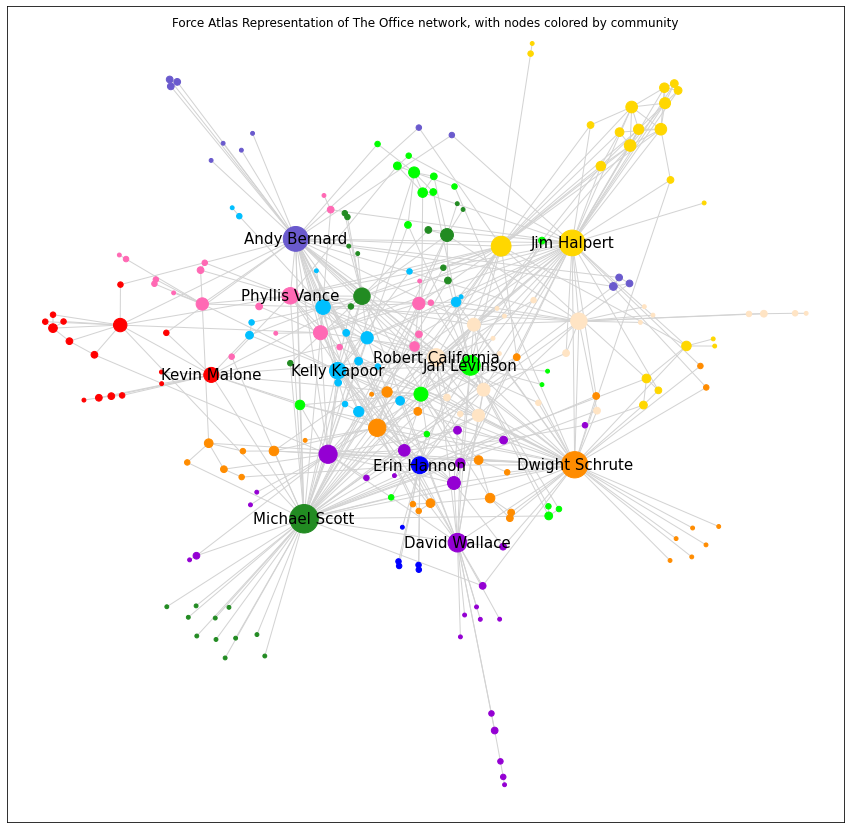

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figsize=(15, 15))
plt.title("Force Atlas Representation of The Office network, with nodes colored by community", c='black',  y=1.0, pad=-20)
d = dict(G.degree)
nx.draw_networkx(G, positions, labels = labels, nodelist=list(d.keys()), node_size=[v*15 for v in d.values()], node_color = list(partition.values()), with_labels=True, edge_color='lightgrey', cmap=newcmp, font_size=15)
plt.show()
plt.savefig('images/communities_netowrk.png')